In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np
import nltk.corpus.reader
import tensorflow as tf

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPool2D, Add, Input, 
    ZeroPadding2D, AveragePooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.initializers import glorot_uniform
from resnet import res_block

IMG_SIZE = 224
BATCH_SIZE = 64

In [ ]:
# Data gathering and (online) augmentation
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    cval=0,
    preprocessing_function=lambda x: (255.-x)/255.
)

train_generator = generator.flow_from_directory('imgs',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                color_mode='grayscale',
                                                class_mode='sparse',
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                shuffle=True,
                                                subset='training'
                                                )
valid_generator = generator.flow_from_directory('imgs',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                color_mode='grayscale',
                                                class_mode='sparse',
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                shuffle=True,
                                                subset='validation'
                                                )

# Save the classes and image size for inference
classes = train_generator.class_indices
classes_dict = {k: v for v, k in classes.items()}
with open('inference_pars.json', 'w') as outfile:
    json.dump(
        {'classes_dict': classes_dict,
         'img_size': IMG_SIZE
         }, outfile)

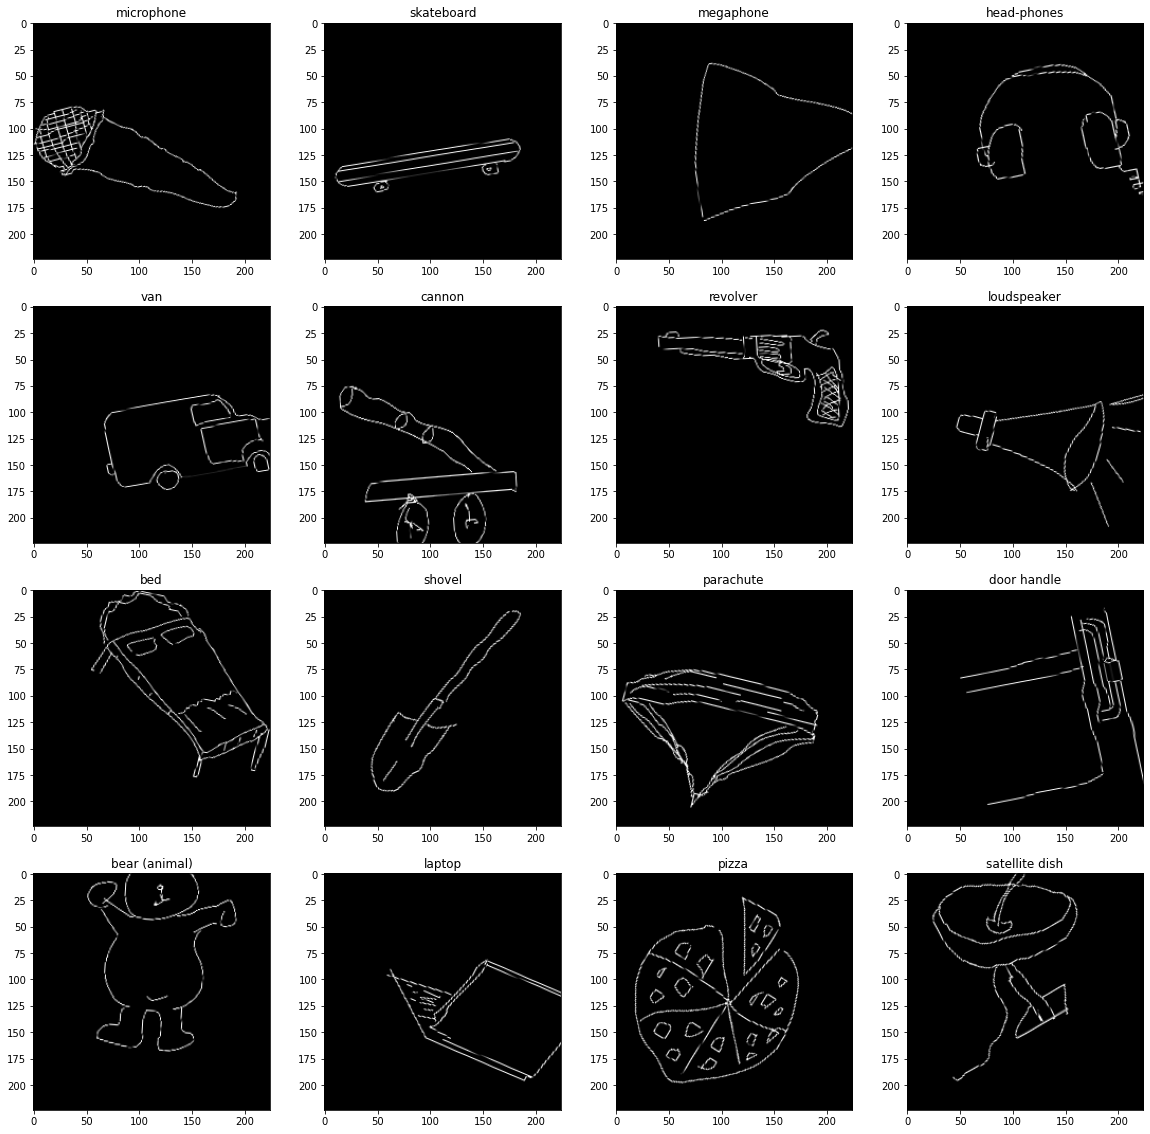

In [47]:
# Print some samples
i=1
fig = plt.figure(figsize=(20,20))
for x, y in valid_generator:
    for xx, yy in zip(x, y):
        fig.add_subplot(4, 4, i)
        plt.imshow(np.squeeze(xx), cmap='gray')
        plt.title(classes_dict[yy])

        i += 1
        if i == 17:
            break
    if i==17:
        break

In [ ]:
# DeepSketch CNN

input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Input tensor shape
X_input = Input(input_shape)

# Conv1
X = Conv2D(64, (7, 7), strides=2, activation='relu')(X_input)
X = MaxPool2D((3,3), strides=2)(X)
# Conv2
X = ZeroPadding2D(2)(X)
X = Conv2D(128, (5, 5), strides=2, activation='relu')(X)
X = MaxPool2D((3,3), strides=2)(X)
# Conv3
X = ZeroPadding2D(3)(X)
X = Conv2D(256, (3, 3), strides=1, activation='relu')(X)
X = MaxPool2D((3, 3), strides=1)(X)
# Conv4
X = Conv2D(512, (3, 3), strides=2, activation='relu')(X)
X = MaxPool2D((3,3), strides=1)(X)
# Conv5
X = Conv2D(4096, (5, 5), activation='relu')(X)
X = Dropout(0.2)(X)
X = Conv2D(250, (1, 1))(X)
X = Flatten()(X)

model = Model(inputs=X_input, outputs=X)
model.summary()

In [ ]:
model.compile(optimizer=Adam(0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cp_cb = ModelCheckpoint('checkpoint', save_best_only=True, verbose=1)
es_cb = EarlyStopping(patience=10)
lr_cb = ReduceLROnPlateau(factor=0.5, patience=4, verbose=True)
tb_cb = TensorBoard('logs', write_graph=False)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.fit(train_generator, epochs=100, validation_data=valid_generator, callbacks=[cp_cb, es_cb, lr_cb, tb_cb])

In [27]:
model = tf.keras.models.load_model('checkpoint')

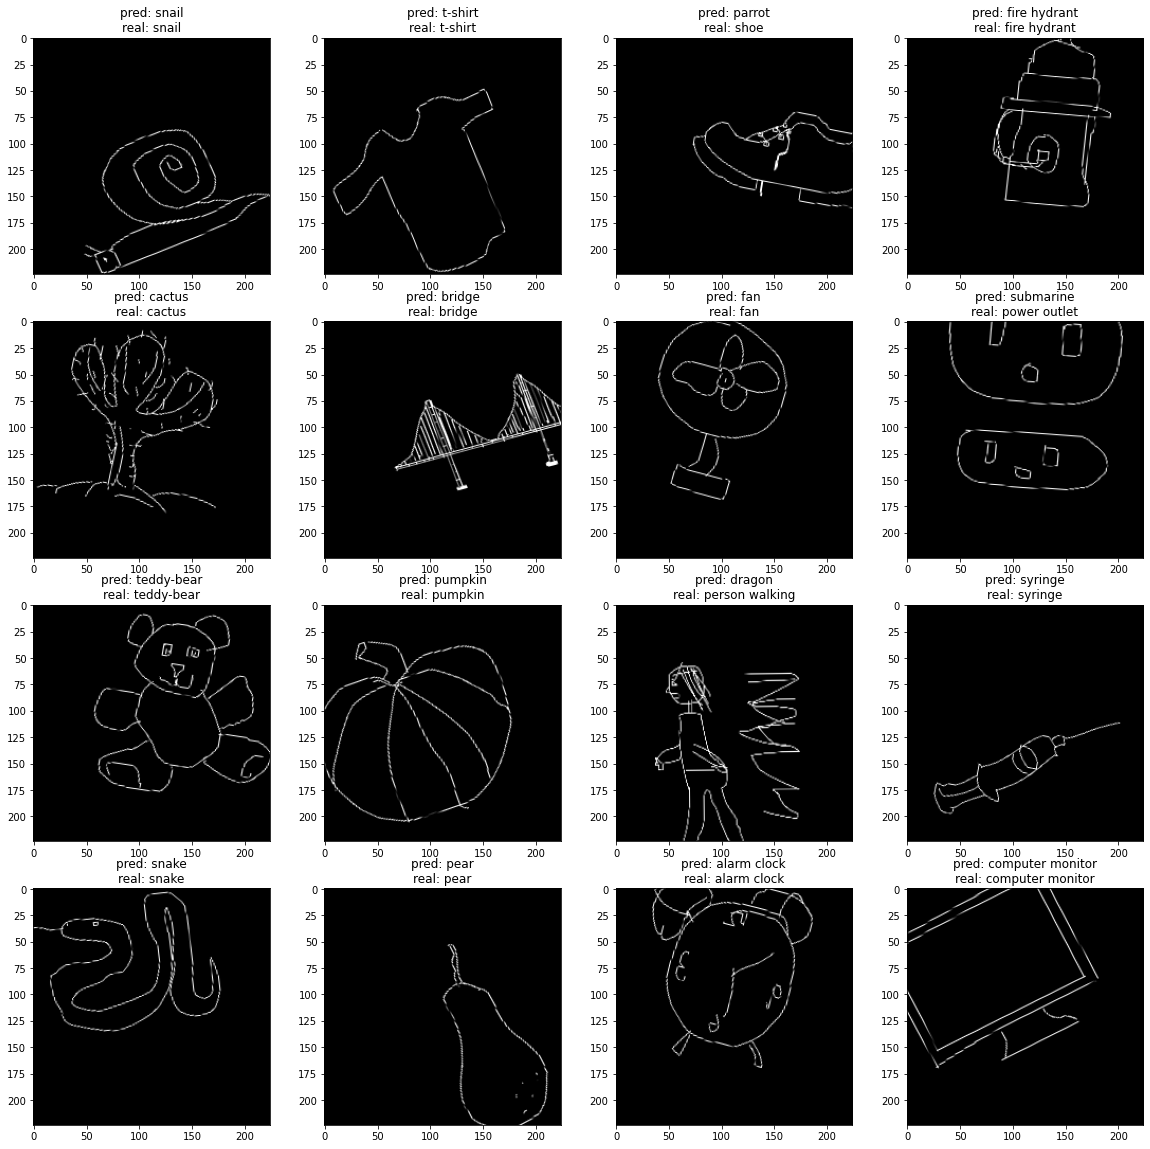

In [46]:
i=1
fig = plt.figure(figsize=(20,20))
for x, y in valid_generator:
    for xx, yy in zip(x, y):
        fig.add_subplot(4, 4, i)
        prediction = model(np.expand_dims(xx, axis=0))
        pred_class = int(np.argmax(prediction))
        plt.imshow(np.squeeze(xx), cmap='gray')
        plt.title(f'pred: {classes_dict[pred_class]}\nreal: {classes_dict[yy]}')

        i += 1
        if i == 17:
            break
    if i==17:
        break